In [138]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


READING THE DATA

In [139]:
train=pd.read_csv('/content/drive/MyDrive/store sales/train.csv')
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [140]:
test=pd.read_csv('/content/drive/MyDrive/store sales/test.csv')
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [141]:
stores=pd.read_csv('/content/drive/MyDrive/store sales/stores.csv')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [142]:
oil=pd.read_csv('/content/drive/MyDrive/store sales/oil.csv')
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [143]:
holiday=pd.read_csv('/content/drive/MyDrive/store sales/holidays_events.csv')
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [144]:
transaction=pd.read_csv('/content/drive/MyDrive/store sales/transactions.csv')
transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [145]:
train.shape
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [146]:
test.shape
test.info()
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


,id,store_nbr,onpromotion
count,2.851200e+04,28512.000000,28512.000000
mean,3.015144e+06,27.500000,6.965383
std,8.230850e+03,15.586057,20.683952
min,3.000888e+06,1.000000,0.000000
25%,3.008016e+06,14.000000,0.000000
50%,3.015144e+06,27.500000,0.000000
75%,3.022271e+06,41.000000,6.000000
max,3.029399e+06,54.000000,646.000000


In [147]:
oil.shape
oil.info()
oil.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


In [148]:
transaction.shape
transaction.info()
transaction.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


In [149]:
holiday.shape
holiday.info()
holiday.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338


In [150]:
stores.shape
stores.info()
stores.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


NULL VALUES IN DATASET

In [151]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [152]:
test.isnull().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [153]:
stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [154]:
transaction.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [155]:
holiday.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [156]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

<Axes: >

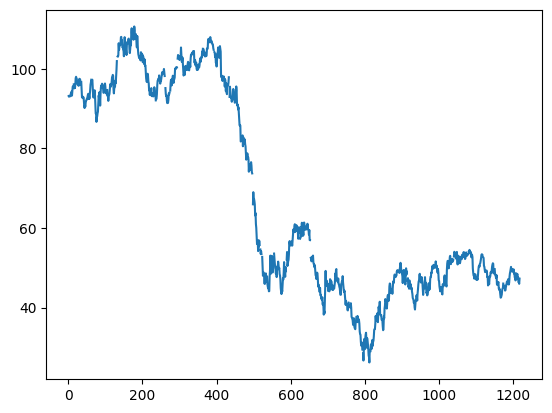

In [157]:
oil['dcoilwtico'].plot(kind = "line")

DATA PREPROCESSING

In [158]:
missing_indices = oil[oil['dcoilwtico'].isnull()].index

for index in missing_indices:
    prev_value = oil.at[index - 1, 'dcoilwtico'] if index > 0 else np.nan
    next_value = oil.at[index + 1, 'dcoilwtico'] if index < len(oil) - 1 else np.nan
    mean_value = np.nanmean([prev_value, next_value])
    oil.loc[index, 'dcoilwtico'] = mean_value

In [159]:
oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

<Axes: >

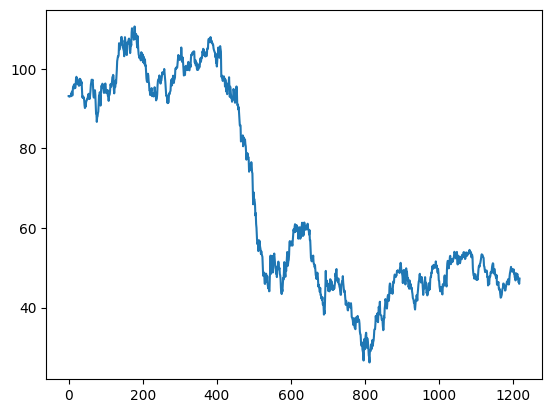

In [160]:
oil['dcoilwtico'].plot(kind = "line")

MERGING DATASET

In [161]:
train_df=train.merge(holiday,on='date',how='left')
train_df=train_df.merge(oil,on='date',how='left')
train_df=train_df.merge(stores,on='store_nbr',how='left')
train_df=train_df.merge(transaction,on=['date','store_nbr'],how='left')
train_df=train_df.rename(columns={"dcoilwtico":"oil_price"})
train_df

,id,date,store_nbr,family,sales,onpromotion,type_x,locale,locale_name,description,transferred,oil_price,city,state,type_y,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Quito,Pichincha,D,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6,2155.0
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6,2155.0
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6,2155.0
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6,2155.0


In [162]:
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100
print(missing_percentage)

id               0.000000
date             0.000000
store_nbr        0.000000
family           0.000000
sales            0.000000
onpromotion      0.000000
type_x          83.547258
locale          83.547258
locale_name     83.547258
description     83.547258
transferred     83.547258
oil_price       28.763127
city             0.000000
state            0.000000
type_y           0.000000
cluster          0.000000
transactions     8.156143
dtype: float64


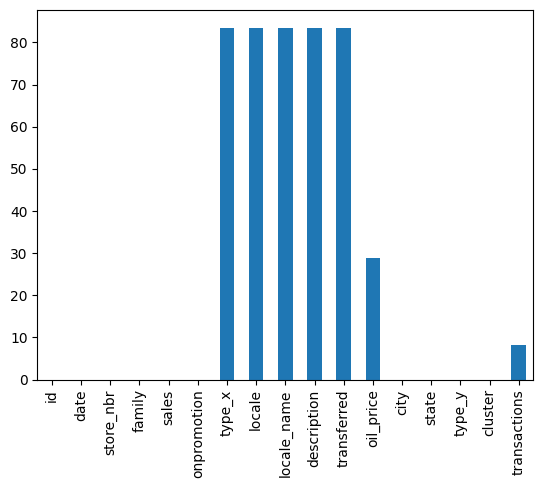

In [163]:
missing_data=train_df.isnull().mean()*100
missing_data.plot(kind='bar')
plt.show()

In [164]:
train_df.loc[train_df['sales'] == 0.000, 'transactions'] = 0

USING INTERPOLATION METHOD TO REPLACE NULL VALUES IN OIL DATA SET

In [165]:
train_df['oil_price'].interpolate(method='linear', inplace=True)

In [166]:
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100
print(missing_percentage)

id               0.000000
date             0.000000
store_nbr        0.000000
family           0.000000
sales            0.000000
onpromotion      0.000000
type_x          83.547258
locale          83.547258
locale_name     83.547258
description     83.547258
transferred     83.547258
oil_price        0.000000
city             0.000000
state            0.000000
type_y           0.000000
cluster          0.000000
transactions     0.106340
dtype: float64


In [167]:
train_df

,id,date,store_nbr,family,sales,onpromotion,type_x,locale,locale_name,description,transferred,oil_price,city,state,type_y,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Quito,Pichincha,D,13,0.0
1,1,2013-01-01,1,BABY CARE,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Quito,Pichincha,D,13,0.0
2,2,2013-01-01,1,BEAUTY,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Quito,Pichincha,D,13,0.0
3,3,2013-01-01,1,BEVERAGES,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Quito,Pichincha,D,13,0.0
4,4,2013-01-01,1,BOOKS,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Quito,Pichincha,D,13,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6,2155.0
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6,2155.0
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6,2155.0
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6,2155.0


REPLACING "NO" IN TUPLES HAVING NULL VALUES(SINCE DELETING 80%+ TUPLES IS NOT A GOOD OPTION) AND NOT EVERY DAY IS A HOLIDAY

In [168]:
train_df['type_x'].fillna('no', inplace=True)
train_df['locale'].fillna('no', inplace=True)
train_df['locale_name'].fillna('no', inplace=True)
train_df['description'].fillna('no', inplace=True)
train_df['transferred']=train_df['transferred'].fillna(train_df['transferred'].mode()[0])

In [169]:
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100
print(missing_percentage)

id              0.00000
date            0.00000
store_nbr       0.00000
family          0.00000
sales           0.00000
onpromotion     0.00000
type_x          0.00000
locale          0.00000
locale_name     0.00000
description     0.00000
transferred     0.00000
oil_price       0.00000
city            0.00000
state           0.00000
type_y          0.00000
cluster         0.00000
transactions    0.10634
dtype: float64


DROP TUPLES WHERE WE CAN'T REPLACE ANY VALUE

In [170]:
train_df.dropna(subset=['transactions'], inplace=True)

In [171]:
train_df['date'] = pd.to_datetime(train_df.date)
train_df['year'] = pd.DatetimeIndex(train_df.date).year
train_df['month'] = pd.DatetimeIndex(train_df.date).month
train_df['day'] = pd.DatetimeIndex(train_df.date).day
train_df['weekday'] = pd.DatetimeIndex(train_df.date).weekday

In [172]:
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100
print(missing_percentage)

id              0.0
date            0.0
store_nbr       0.0
family          0.0
sales           0.0
onpromotion     0.0
type_x          0.0
locale          0.0
locale_name     0.0
description     0.0
transferred     0.0
oil_price       0.0
city            0.0
state           0.0
type_y          0.0
cluster         0.0
transactions    0.0
year            0.0
month           0.0
day             0.0
weekday         0.0
dtype: float64


SAME OPERATIONS PERFORMED ON TEST DATASET

In [173]:
test_df=test.merge(holiday,on='date',how='left')
test_df=test_df.merge(oil,on='date',how='left')
test_df=test_df.merge(stores,on='store_nbr',how='left')
test_df=test_df.merge(transaction,on=['date','store_nbr'],how='left')
test_df=test_df.rename(columns={"dcoilwtico":"oil_price"})
test_df

,id,date,store_nbr,family,onpromotion,type_x,locale,locale_name,description,transferred,oil_price,city,state,type_y,cluster,transactions
0,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN,NaN,NaN,NaN,NaN,46.80,Quito,Pichincha,D,13,NaN
1,3000889,2017-08-16,1,BABY CARE,0,NaN,NaN,NaN,NaN,NaN,46.80,Quito,Pichincha,D,13,NaN
2,3000890,2017-08-16,1,BEAUTY,2,NaN,NaN,NaN,NaN,NaN,46.80,Quito,Pichincha,D,13,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,NaN,NaN,NaN,NaN,NaN,46.80,Quito,Pichincha,D,13,NaN
4,3000892,2017-08-16,1,BOOKS,0,NaN,NaN,NaN,NaN,NaN,46.80,Quito,Pichincha,D,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,NaN,NaN,NaN,NaN,NaN,47.26,Quito,Pichincha,B,6,NaN
28508,3029396,2017-08-31,9,PREPARED FOODS,0,NaN,NaN,NaN,NaN,NaN,47.26,Quito,Pichincha,B,6,NaN
28509,3029397,2017-08-31,9,PRODUCE,1,NaN,NaN,NaN,NaN,NaN,47.26,Quito,Pichincha,B,6,NaN
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,NaN,NaN,NaN,NaN,NaN,47.26,Quito,Pichincha,B,6,NaN


In [174]:
test_df['type_x'].fillna('no', inplace=True)
test_df['locale'].fillna('no', inplace=True)
test_df['locale_name'].fillna('no', inplace=True)
test_df['description'].fillna('no', inplace=True)
test_df['transferred']=test_df['transferred'].fillna(test_df['transferred'].mode()[0])

In [175]:
test_df['oil_price'].interpolate(method='linear', inplace=True)

In [176]:
missing_values = test_df.isnull().sum()
missing_percentage = (missing_values / len(test_df)) * 100
print(missing_percentage)

id                0.0
date              0.0
store_nbr         0.0
family            0.0
onpromotion       0.0
type_x            0.0
locale            0.0
locale_name       0.0
description       0.0
transferred       0.0
oil_price         0.0
city              0.0
state             0.0
type_y            0.0
cluster           0.0
transactions    100.0
dtype: float64


In [177]:
test_df['date'] = pd.to_datetime(test_df.date)
test_df['year'] = pd.DatetimeIndex(test_df.date).year
test_df['month'] = pd.DatetimeIndex(test_df.date).month
test_df['day'] = pd.DatetimeIndex(test_df.date).day
test_df['weekday'] = pd.DatetimeIndex(test_df.date).weekday

In [178]:
test_df = test_df.drop('transactions', axis=1)

In [179]:
missing_values = test_df.isnull().sum()
missing_percentage = (missing_values / len(test_df)) * 100
print(missing_percentage)

id             0.0
date           0.0
store_nbr      0.0
family         0.0
onpromotion    0.0
type_x         0.0
locale         0.0
locale_name    0.0
description    0.0
transferred    0.0
oil_price      0.0
city           0.0
state          0.0
type_y         0.0
cluster        0.0
year           0.0
month          0.0
day            0.0
weekday        0.0
dtype: float64


CONVERTING CATEGORICAL DATA TO NUMERIC DATA

In [180]:
cat_cols = ['city', 'state', 'family', 'type_y', 'type_x', 'locale', 'locale_name', 'description', 'transferred']

for col in cat_cols:
    train_df[col] = pd.factorize(train_df[col], na_sentinel=-1)[0]

    train_df[col] = train_df[col].replace(-1, float('nan'))

print(train_df)

<ipython-input-180-48989fbc94f6>:4: FutureWarning: Specifying `na_sentinel=-1` is deprecated, specify `use_na_sentinel=True` instead.
  train_df[col] = pd.factorize(train_df[col], na_sentinel=-1)[0]
<ipython-input-180-48989fbc94f6>:4: FutureWarning: Specifying `na_sentinel=-1` is deprecated, specify `use_na_sentinel=True` instead.
  train_df[col] = pd.factorize(train_df[col], na_sentinel=-1)[0]
<ipython-input-180-48989fbc94f6>:4: FutureWarning: Specifying `na_sentinel=-1` is deprecated, specify `use_na_sentinel=True` instead.
  train_df[col] = pd.factorize(train_df[col], na_sentinel=-1)[0]
<ipython-input-180-48989fbc94f6>:4: FutureWarning: Specifying `na_sentinel=-1` is deprecated, specify `use_na_sentinel=True` instead.
  train_df[col] = pd.factorize(train_df[col], na_sentinel=-1)[0]
<ipython-input-180-48989fbc94f6>:4: FutureWarning: Specifying `na_sentinel=-1` is deprecated, specify `use_na_sentinel=True` instead.
  train_df[col] = pd.factorize(train_df[col], na_sentinel=-1)[0]
<ipyt

              id       date  store_nbr  family     sales  onpromotion  type_x  \
0              0 2013-01-01          1       0     0.000            0       0   
1              1 2013-01-01          1       1     0.000            0       0   
2              2 2013-01-01          1       2     0.000            0       0   
3              3 2013-01-01          1       3     0.000            0       0   
4              4 2013-01-01          1       4     0.000            0       0   
...          ...        ...        ...     ...       ...          ...     ...   
3054343  3000883 2017-08-15          9      28   438.133            0       0   
3054344  3000884 2017-08-15          9      29   154.553            1       0   
3054345  3000885 2017-08-15          9      30  2419.729          148       0   
3054346  3000886 2017-08-15          9      31   121.000            8       0   
3054347  3000887 2017-08-15          9      32    16.000            0       0   

         locale  locale_nam

In [181]:
cat_cols2 = ['city', 'state', 'family','type_y','type_x','locale','locale_name','description','transferred']

for col in cat_cols2:
    test_df[col] = pd.factorize(test_df[col], na_sentinel=-1)[0]

    test_df[col] = test_df[col].replace(-1, float('nan'))

print(test_df)

            id       date  store_nbr  family  onpromotion  type_x  locale  \
0      3000888 2017-08-16          1       0            0       0       0   
1      3000889 2017-08-16          1       1            0       0       0   
2      3000890 2017-08-16          1       2            2       0       0   
3      3000891 2017-08-16          1       3           20       0       0   
4      3000892 2017-08-16          1       4            0       0       0   
...        ...        ...        ...     ...          ...     ...     ...   
28507  3029395 2017-08-31          9      28            1       0       0   
28508  3029396 2017-08-31          9      29            0       0       0   
28509  3029397 2017-08-31          9      30            1       0       0   
28510  3029398 2017-08-31          9      31            9       0       0   
28511  3029399 2017-08-31          9      32            0       0       0   

       locale_name  description  transferred  oil_price  city  state  type_

<ipython-input-181-51e63da8dcf7>:4: FutureWarning: Specifying `na_sentinel=-1` is deprecated, specify `use_na_sentinel=True` instead.
  test_df[col] = pd.factorize(test_df[col], na_sentinel=-1)[0]
<ipython-input-181-51e63da8dcf7>:4: FutureWarning: Specifying `na_sentinel=-1` is deprecated, specify `use_na_sentinel=True` instead.
  test_df[col] = pd.factorize(test_df[col], na_sentinel=-1)[0]
<ipython-input-181-51e63da8dcf7>:4: FutureWarning: Specifying `na_sentinel=-1` is deprecated, specify `use_na_sentinel=True` instead.
  test_df[col] = pd.factorize(test_df[col], na_sentinel=-1)[0]
<ipython-input-181-51e63da8dcf7>:4: FutureWarning: Specifying `na_sentinel=-1` is deprecated, specify `use_na_sentinel=True` instead.
  test_df[col] = pd.factorize(test_df[col], na_sentinel=-1)[0]
<ipython-input-181-51e63da8dcf7>:4: FutureWarning: Specifying `na_sentinel=-1` is deprecated, specify `use_na_sentinel=True` instead.
  test_df[col] = pd.factorize(test_df[col], na_sentinel=-1)[0]
<ipython-input-

In [182]:
train_df['date']=pd.to_datetime(train_df['date'])
train_df.info

<bound method DataFrame.info of               id       date  store_nbr  family     sales  onpromotion  type_x  \
0              0 2013-01-01          1       0     0.000            0       0   
1              1 2013-01-01          1       1     0.000            0       0   
2              2 2013-01-01          1       2     0.000            0       0   
3              3 2013-01-01          1       3     0.000            0       0   
4              4 2013-01-01          1       4     0.000            0       0   
...          ...        ...        ...     ...       ...          ...     ...   
3054343  3000883 2017-08-15          9      28   438.133            0       0   
3054344  3000884 2017-08-15          9      29   154.553            1       0   
3054345  3000885 2017-08-15          9      30  2419.729          148       0   
3054346  3000886 2017-08-15          9      31   121.000            8       0   
3054347  3000887 2017-08-15          9      32    16.000            0       0

In [183]:
train_df['year'] = pd.DatetimeIndex(train_df.date).year
train_df['month'] = pd.DatetimeIndex(train_df.date).month
train_df['day'] = pd.DatetimeIndex(train_df.date).day
train_df['weekday'] = pd.DatetimeIndex(train_df.date).weekday

In [184]:
test_df['date']=pd.to_datetime(test_df['date'])
test_df.info

<bound method DataFrame.info of             id       date  store_nbr  family  onpromotion  type_x  locale  \
0      3000888 2017-08-16          1       0            0       0       0   
1      3000889 2017-08-16          1       1            0       0       0   
2      3000890 2017-08-16          1       2            2       0       0   
3      3000891 2017-08-16          1       3           20       0       0   
4      3000892 2017-08-16          1       4            0       0       0   
...        ...        ...        ...     ...          ...     ...     ...   
28507  3029395 2017-08-31          9      28            1       0       0   
28508  3029396 2017-08-31          9      29            0       0       0   
28509  3029397 2017-08-31          9      30            1       0       0   
28510  3029398 2017-08-31          9      31            9       0       0   
28511  3029399 2017-08-31          9      32            0       0       0   

       locale_name  description  transferre

In [185]:
test_df['year'] = pd.DatetimeIndex(test_df.date).year
test_df['month'] = pd.DatetimeIndex(test_df.date).month
test_df['day'] = pd.DatetimeIndex(test_df.date).day
test_df['weekday'] = pd.DatetimeIndex(test_df.date).weekday

In [186]:
train_df

,id,date,store_nbr,family,sales,onpromotion,type_x,locale,locale_name,description,...,oil_price,city,state,type_y,cluster,transactions,year,month,day,weekday
0,0,2013-01-01,1,0,0.000,0,0,0,0,0,...,93.14,0,0,0,13,0.0,2013,1,1,1
1,1,2013-01-01,1,1,0.000,0,0,0,0,0,...,93.14,0,0,0,13,0.0,2013,1,1,1
2,2,2013-01-01,1,2,0.000,0,0,0,0,0,...,93.14,0,0,0,13,0.0,2013,1,1,1
3,3,2013-01-01,1,3,0.000,0,0,0,0,0,...,93.14,0,0,0,13,0.0,2013,1,1,1
4,4,2013-01-01,1,4,0.000,0,0,0,0,0,...,93.14,0,0,0,13,0.0,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,28,438.133,0,0,2,6,27,...,47.57,0,0,2,6,2155.0,2017,8,15,1
3054344,3000884,2017-08-15,9,29,154.553,1,0,2,6,27,...,47.57,0,0,2,6,2155.0,2017,8,15,1
3054345,3000885,2017-08-15,9,30,2419.729,148,0,2,6,27,...,47.57,0,0,2,6,2155.0,2017,8,15,1
3054346,3000886,2017-08-15,9,31,121.000,8,0,2,6,27,...,47.57,0,0,2,6,2155.0,2017,8,15,1


In [187]:
test_df

,id,date,store_nbr,family,onpromotion,type_x,locale,locale_name,description,transferred,oil_price,city,state,type_y,cluster,year,month,day,weekday
0,3000888,2017-08-16,1,0,0,0,0,0,0,0,46.80,0,0,0,13,2017,8,16,2
1,3000889,2017-08-16,1,1,0,0,0,0,0,0,46.80,0,0,0,13,2017,8,16,2
2,3000890,2017-08-16,1,2,2,0,0,0,0,0,46.80,0,0,0,13,2017,8,16,2
3,3000891,2017-08-16,1,3,20,0,0,0,0,0,46.80,0,0,0,13,2017,8,16,2
4,3000892,2017-08-16,1,4,0,0,0,0,0,0,46.80,0,0,0,13,2017,8,16,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,28,1,0,0,0,0,0,47.26,0,0,2,6,2017,8,31,3
28508,3029396,2017-08-31,9,29,0,0,0,0,0,0,47.26,0,0,2,6,2017,8,31,3
28509,3029397,2017-08-31,9,30,1,0,0,0,0,0,47.26,0,0,2,6,2017,8,31,3
28510,3029398,2017-08-31,9,31,9,0,0,0,0,0,47.26,0,0,2,6,2017,8,31,3


In [188]:
import pandas as pd


mean_sales_per_date = train_df.groupby('date')['sales'].mean()

overall_mean_sales = mean_sales_per_date.mean()

print("Mean sales across all dates:", overall_mean_sales)

Mean sales across all dates: 357.1875677451489


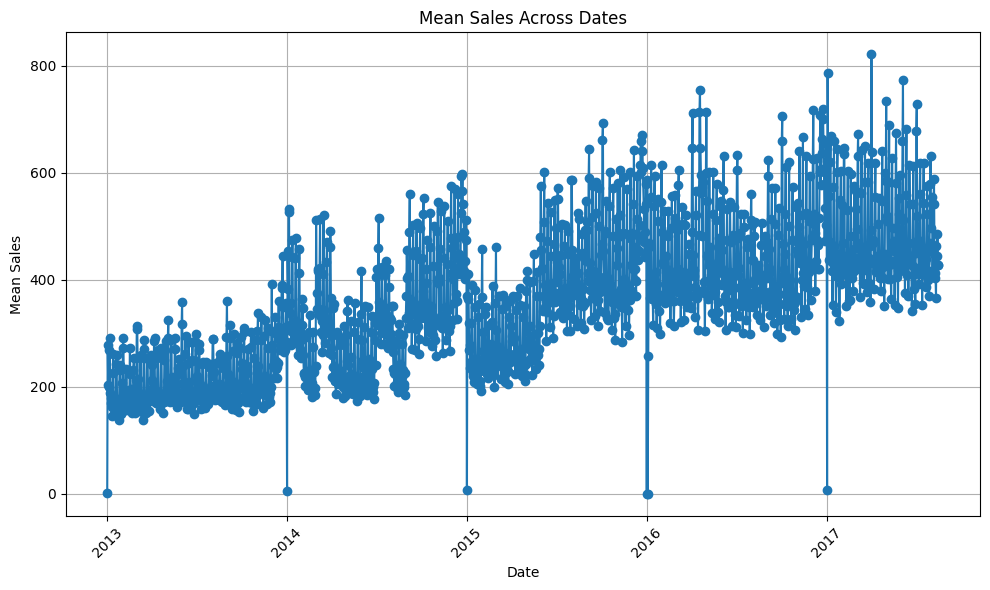

In [189]:
import pandas as pd
import matplotlib.pyplot as plt

mean_sales_per_date = train_df.groupby('date')['sales'].mean()

plt.figure(figsize=(10, 6))
plt.plot(mean_sales_per_date.index, mean_sales_per_date.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Mean Sales')
plt.title('Mean Sales Across Dates')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [190]:
import pandas as pd



median_sales = train_df['sales'].median()

print("Median sales across all dates:", median_sales)

Median sales across all dates: 11.0


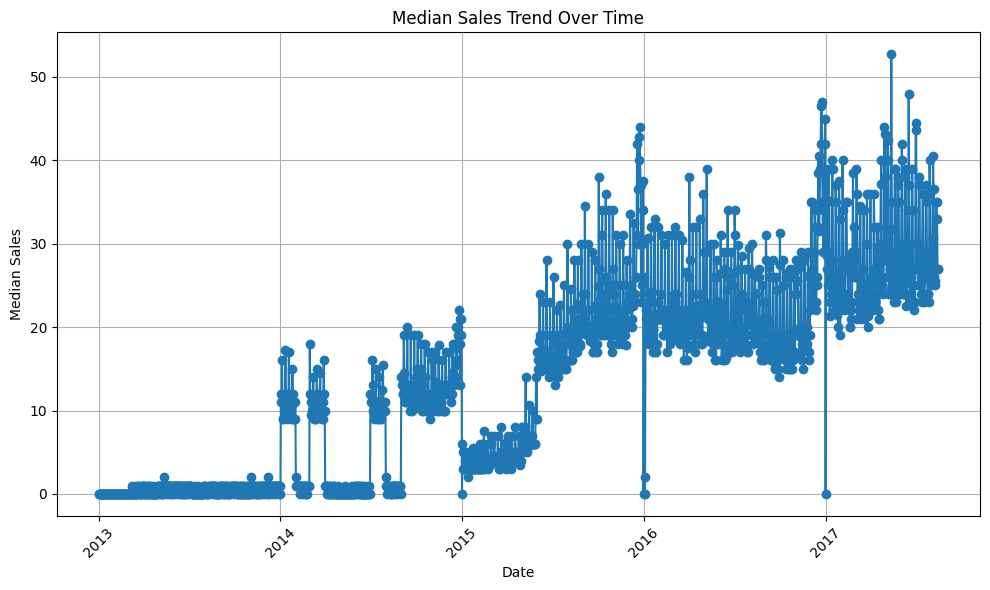

In [191]:
import pandas as pd
import matplotlib.pyplot as plt



median_sales_by_date = train_df.groupby('date')['sales'].median()

plt.figure(figsize=(10, 6))
plt.plot(median_sales_by_date.index, median_sales_by_date.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Median Sales')
plt.title('Median Sales Trend Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [192]:
import pandas as pd




train_df['sales'] = pd.to_numeric(train_df['sales'], errors='coerce')


sales_range = train_df['sales'].max() - train_df['sales'].min()

print("Range of sales:", sales_range)


Range of sales: 124717.0


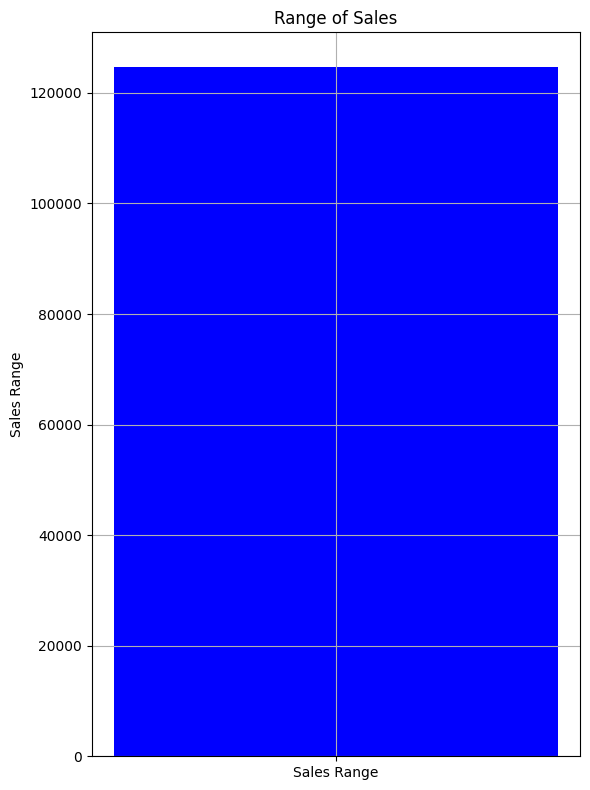

In [193]:
import pandas as pd
import matplotlib.pyplot as plt


train_df['sales'] = pd.to_numeric(train_df['sales'], errors='coerce')

sales_range = train_df['sales'].max() - train_df['sales'].min()

plt.figure(figsize=(6, 8))
plt.bar(['Sales Range'], [sales_range], color='b')
plt.ylabel('Sales Range')
plt.title('Range of Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


In [194]:
import pandas as pd


train_df['sales'] = pd.to_numeric(train_df['sales'], errors='coerce')

sales_std = train_df['sales'].std()

print("Standard Deviation of Sales:", sales_std)


Standard Deviation of Sales: 1106.0619395653996


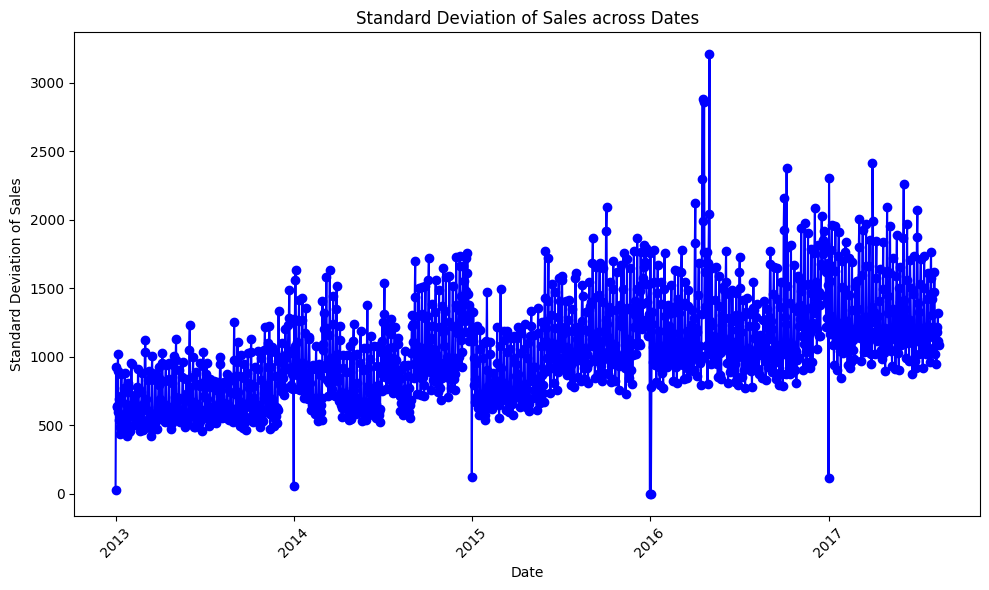

In [195]:
import pandas as pd
import matplotlib.pyplot as plt


train_df['sales'] = pd.to_numeric(train_df['sales'], errors='coerce')

sales_std_by_date = train_df.groupby('date')['sales'].std()

plt.figure(figsize=(10, 6))
plt.plot(sales_std_by_date.index, sales_std_by_date.values, marker='o', linestyle='-', color='b')

plt.xlabel('Date')
plt.ylabel('Standard Deviation of Sales')
plt.title('Standard Deviation of Sales across Dates')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [196]:
import pandas as pd


train_df['sales'] = pd.to_numeric(train_df['sales'], errors='coerce')

sales_variance = train_df['sales'].var()

print("Variance of Sales:", sales_variance)


Variance of Sales: 1223373.0141551734


In [197]:
import pandas as pd


train_df['sales'] = pd.to_numeric(train_df['sales'], errors='coerce')

sales_mean = train_df['sales'].mean()

squared_diff = (train_df['sales'] - sales_mean) ** 2

average_squared_diff = squared_diff.mean()

print("Average of the squared differences from the mean:", average_squared_diff)



Average of the squared differences from the mean: 1223372.613193876


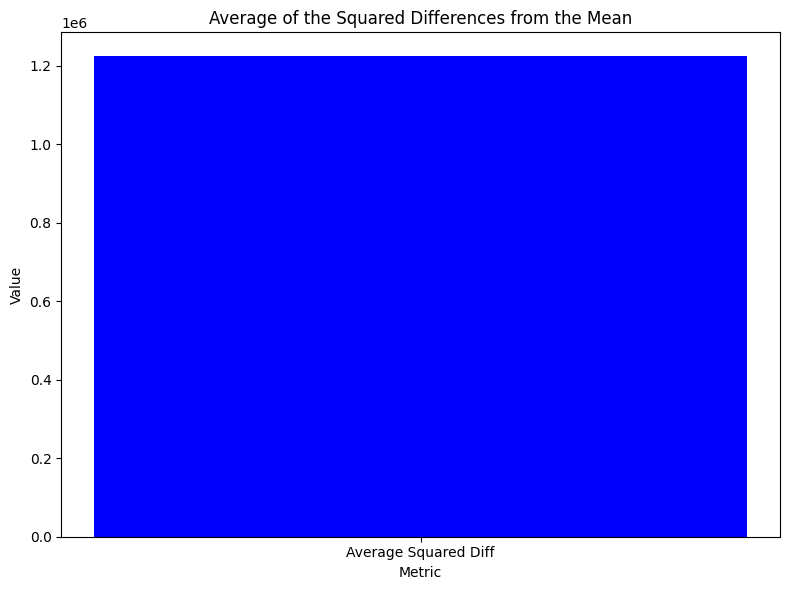

In [198]:
import pandas as pd
import matplotlib.pyplot as plt


train_df['sales'] = pd.to_numeric(train_df['sales'], errors='coerce')

sales_mean = train_df['sales'].mean()

squared_diff = (train_df['sales'] - sales_mean) ** 2

average_squared_diff = squared_diff.mean()

plt.figure(figsize=(8, 6))
plt.bar('Average Squared Diff', average_squared_diff, color='blue')

plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Average of the Squared Differences from the Mean')

plt.tight_layout()
plt.show()


FEATURE SELECTION 

<ipython-input-199-7de89f6d22a2>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(),annot=True)


Text(0.5, 1.0, 'Corelation Heatmap for Store sales data')

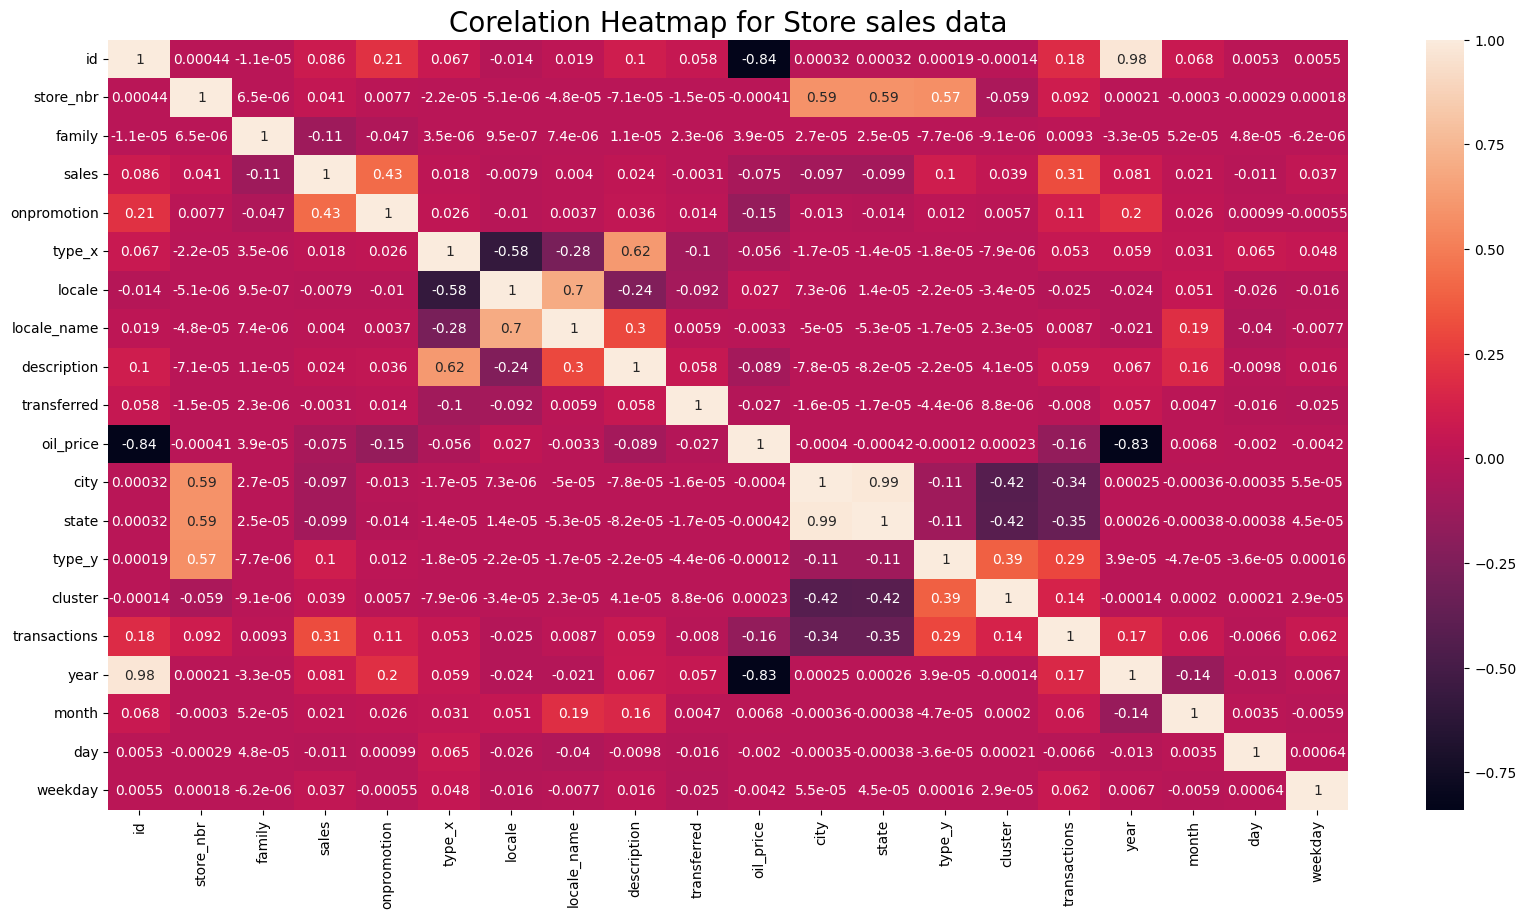

In [199]:
plt.figure(figsize=(20,10))
sns.heatmap(train_df.corr(),annot=True)
plt.title('Corelation Heatmap for Store sales data',size=20)

DATA MODELLING USING XGBOOST
MINMAX SCALAR USED TO PREVENT BIASED DATA PERFORMANCE

In [200]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb


scaler = MinMaxScaler()
numeric_features = ['onpromotion','family','type_x']
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])


train_ts = train_df.set_index('date')['sales']
X_train = train_df.set_index('date')[numeric_features]
X_test = test_df.set_index('date')[numeric_features]

model = xgb.XGBRegressor(    )
model.fit(X_train, train_ts)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

PREDICTED SALES

In [201]:
test_df['predicted_sales'] = model.predict(X_test)


print(test_df[['id', 'predicted_sales']])


            id  predicted_sales
0      3000888         5.463990
1      3000889        -0.065966
2      3000890        10.857280
3      3000891      3135.829590
4      3000892         0.468346
...        ...              ...
28507  3029395       455.982758
28508  3029396        91.963715
28509  3029397      2346.283203
28510  3029398       198.949921
28511  3029399        15.256320

[28512 rows x 2 columns]


In [202]:
submission=test_df[["id"]]
submission['sales'] = test_df['predicted_sales']
submission


<ipython-input-202-50e7b838098e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['sales'] = test_df['predicted_sales']


,id,sales
0,3000888,5.463990
1,3000889,-0.065966
2,3000890,10.857280
3,3000891,3135.829590
4,3000892,0.468346
...,...,...
28507,3029395,455.982758
28508,3029396,91.963715
28509,3029397,2346.283203
28510,3029398,198.949921


In [203]:
submission['sales'] = submission['sales'].apply(lambda x: max(x, 0))
submission

<ipython-input-203-089329f896cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['sales'] = submission['sales'].apply(lambda x: max(x, 0))


,id,sales
0,3000888,5.463990
1,3000889,0.000000
2,3000890,10.857280
3,3000891,3135.829590
4,3000892,0.468346
...,...,...
28507,3029395,455.982758
28508,3029396,91.963715
28509,3029397,2346.283203
28510,3029398,198.949921


In [204]:
submission.to_csv("submission.csv",index=None)

In [205]:
submission

,id,sales
0,3000888,5.463990
1,3000889,0.000000
2,3000890,10.857280
3,3000891,3135.829590
4,3000892,0.468346
...,...,...
28507,3029395,455.982758
28508,3029396,91.963715
28509,3029397,2346.283203
28510,3029398,198.949921


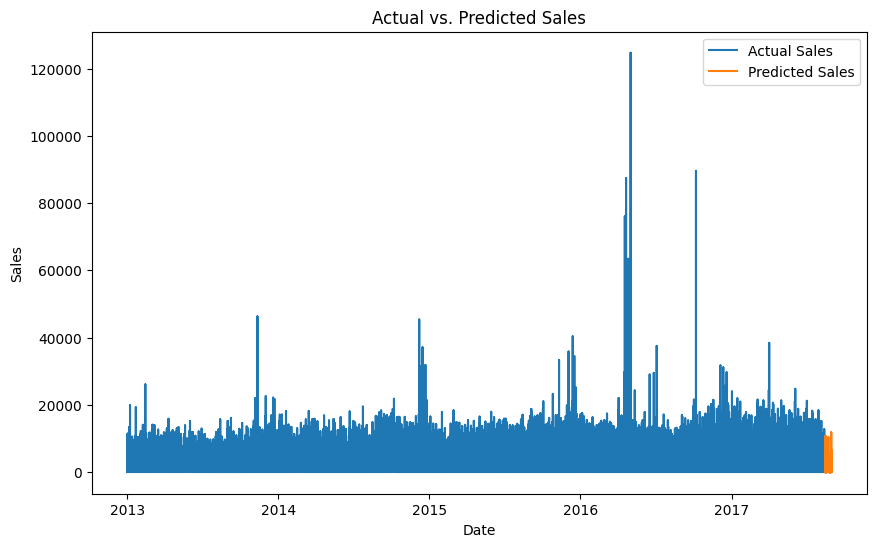

In [206]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_df['date'], train_df['sales'], label='Actual Sales')
plt.plot(test_df['date'], test_df['predicted_sales'], label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Sales')
plt.legend()

plt.show()

In [207]:
supervised_data = train_df
train_data =supervised_data[:-28512]
test_data =supervised_data[-28512:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (3022588, 21)
Test Data Shape:  (28512, 21)


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
scaler = MinMaxScaler()
numeric_features = ['onpromotion','family','type_x','transactions','oil_price']
train_data[numeric_features] = scaler.fit_transform(train_data[numeric_features])
test_data[numeric_features] = scaler.transform(test_data[numeric_features])


train_ts = train_data.set_index('date')['sales']
X_train = train_data.set_index('date')[numeric_features]
X_test = test_data.set_index('date')[numeric_features]

model = xgb.XGBRegressor(    )

model.fit(X_train, train_ts)

<ipython-input-208-ebbdaedbcdb8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[numeric_features] = scaler.fit_transform(train_data[numeric_features])
<ipython-input-208-ebbdaedbcdb8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[numeric_features] = scaler.transform(test_data[numeric_features])


In [ ]:
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# import xgboost as xgb
# from sklearn.ensemble import RandomForestRegressor
# scaler = MinMaxScaler()
# numeric_features = ['onpromotion','family','type_x']
# train_data[numeric_features] = scaler.fit_transform(train_data[numeric_features])
# test_data[numeric_features] = scaler.transform(test_data[numeric_features])


# train_ts = train_data.set_index('date')['sales']
# X_train = train_data.set_index('date')[numeric_features]
# X_test = test_data.set_index('date')[numeric_features]

# model = LinearRegression(    )

# model.fit(X_train, train_ts)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)

rmse = mean_squared_error(test_data['sales'], y_pred, squared=False)
mse = mean_squared_error(test_data['sales'], y_pred)
r2 = r2_score(test_data['sales'], y_pred)

print("RMSE:", rmse)
print("MSE:", mse)
print("R2 Score:", r2)

In [ ]:
y_pred = [max(0, pred_value) for pred_value in y_pred]



In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

filtered_train_df = train_df[(train_df['date'] >= '2017-07-01') & (train_df['date'] <= '2017-08-15')]

plt.plot(filtered_train_df['date'], filtered_train_df['sales'], label='Actual Sales')

plt.xlabel('Date')
plt.ylabel('Sales')

plt.title('Actual vs. Predicted Sales (2017-08-01 to 2017-08-15)')

plt.legend()

plt.xticks(rotation=45)

plt.grid()
plt.show()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

filtered_train_df = train_df[(train_df['date'] >= '2017-07-01') & (train_df['date'] <= '2017-08-15')]
filtered_test_data = test_data[(test_data['date'] >= '2017-07-01') & (test_data['date'] <= '2017-08-15')]

plt.plot(filtered_train_df['date'], filtered_train_df['sales'], label='Actual Sales')
plt.plot(filtered_test_data['date'], y_pred, label='Predicted Sales')

plt.xlabel('Date')
plt.ylabel('Sales')

plt.title('Actual vs. Predicted Sales (2017-08-01 to 2017-08-15)')

plt.legend()

plt.xticks(rotation=45)

plt.grid()
plt.show()
